# Investigating Earthquakes from 1900~ 2016
### Keenan Zucker and James Jang

This notebook aims to explore the iterations we went through when working with Earthquake data and trying to come up with an interesting story. We started with data exploration, before moving into generating a model to fit our data. Upon visualizing those results, we realized it was not a particularily interesting story, so we transitioned to focusing on just California. We then looked at Kernel Density to create predictions of the probabilities of what type of earthquake would hit a given latitude and longitude spot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

import re

%matplotlib inline

/Users/bumho/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
quakes = pd.read_csv("./downloaded/data.csv")

## Initial Data Exploration

We explored the data individually and accumulated some of the important information we found with explanation and our thought process.

### Magnitude Graphing

Distplot shows us an overall trend. We used the an earthquake magnitude classification system shown [HERE](http://www.geo.mtu.edu/UPSeis/magnitude.html). After looking at our dataset, we decided to add a classification called 'tiny' that encompassed anything under a magnitude of 3, sice there was a significant chunk of data that was that small. We then used a barplot to observe what our data looked like.


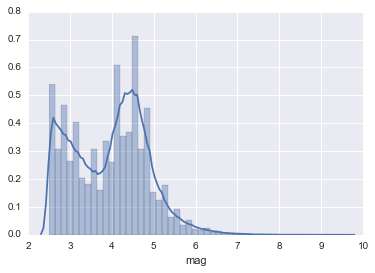

In [3]:
sns.distplot(quakes.mag)

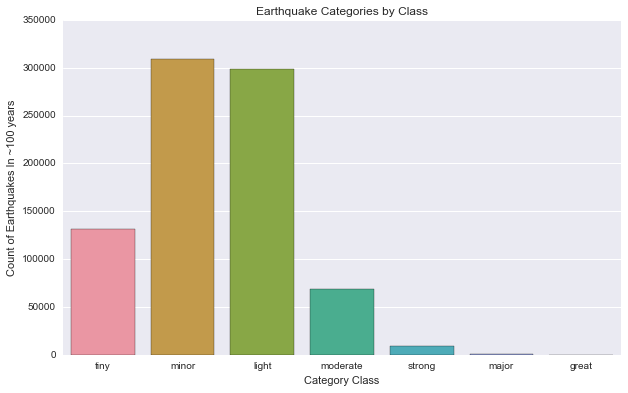

In [4]:
tiny = len(quakes[(quakes.mag < 3)])
minor = len(quakes[(quakes.mag < 4)])
light = len(quakes[(quakes.mag >= 4) & (quakes.mag < 5)])
moderate = len(quakes[(quakes.mag >= 5) & (quakes.mag < 6)])
strong = len(quakes[(quakes.mag >= 6) & (quakes.mag < 7)])
major = len(quakes[(quakes.mag >= 7) & (quakes.mag < 8)])
great = len(quakes[(quakes.mag >= 8)])

names=['tiny', 'minor', 'light', 'moderate', 'strong', 'major', 'great']
counts=[tiny, minor, light, moderate, strong, major, great]

plt.figure(figsize=(10,6))

sns.barplot(names, counts)
sns.plt.title("Earthquake Categories by Class")
sns.axlabel("Category Class", "Count of Earthquakes In ~100 years")

### Depth Graphing

We also wanted to look into depth of the earthquakes in a classification system [HERE](http://earthquake.usgs.gov/learn/topics/seismology/determining_depth.php) that used three categories, shallow intermediate and deep. We then used a bargraph again to visualize the data

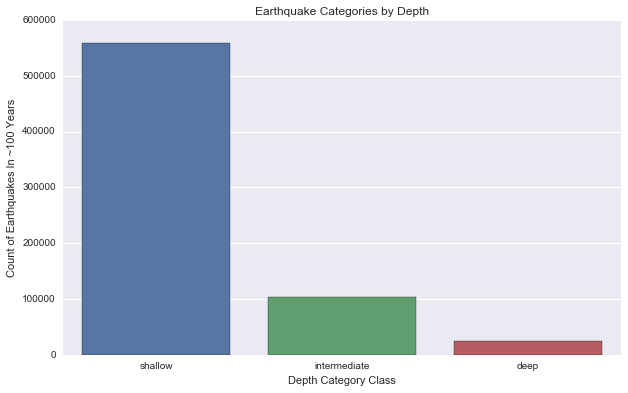

In [5]:
shallow = len(quakes[quakes.depth < 70])
intermediate = len(quakes[(quakes.depth >= 70) & (quakes.depth < 300)])
deep = len(quakes[quakes.depth >= 300])

names = ['shallow', 'intermediate', 'deep']
counts = [shallow, intermediate, deep]

plt.figure(figsize=(10,6))
sns.barplot(names, counts)
sns.plt.title("Earthquake Categories by Depth")
sns.axlabel("Depth Category Class", "Count of Earthquakes In ~100 Years")

### Basemap Visualization

We used a package called basemap to plot all of our points onto the globe. This looked pretty cool, as it basically mapped out most of the faultlines, as there are clearly areas, like the mid-atlantic ridge, that show a clear fault line. 

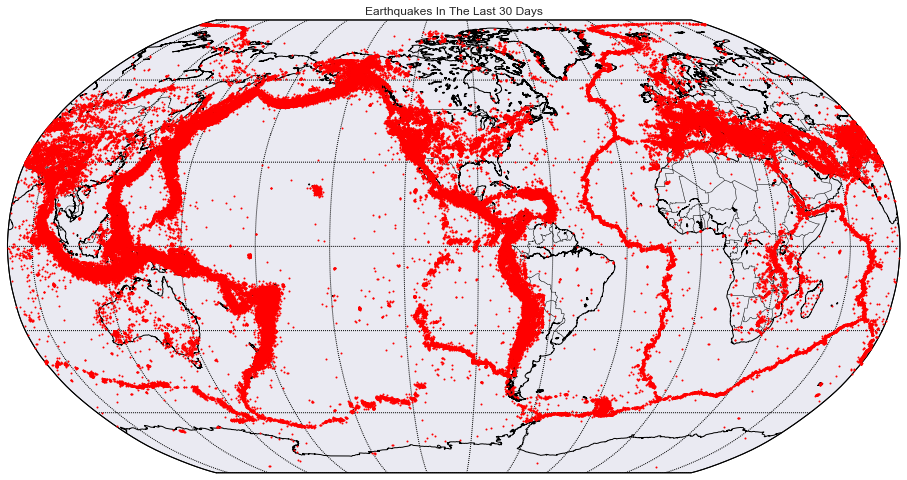

In [6]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(16,12))

my_map = Basemap(projection='robin', lat_0=0, lon_0=-100,
              resolution='l', area_thresh=1000.0)

lats = np.array(quakes.latitude)
longs = np.array(quakes.longitude)
mags = np.array(quakes.mag)
# print lats

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))

x,y = my_map(longs, lats)
my_map.plot(x, y, 'ro', markersize=2.0)
    
plt.title('Earthquakes In The Last 30 Days')
plt.show()

We then wanted to see where the larger earthquakes were located, so we used a function to use a different color to plot each of the points based off of magnitude. My computer couldn't handle plotting all 650,000 points with all of the different colors, so I limited it to a 10% sample of the data. 

In [7]:
def get_marker_color(magnitude):
    if magnitude < 3.0:
        return ('wo') # tiny
    elif magnitude < 4.0:
        return ('go') # minor
    elif magnitude < 5.0:
        return ('yo') # light
    elif magnitude < 5.0:
        return ('mo') # moderate
    elif magnitude < 6.0:
        return ('ro') # strong
    elif magnitude < 7.0:
        return ('ko') # major
    else:
        return ('ko') # great
    

In [8]:
quakes["color"] = quakes["mag"].apply(get_marker_color)

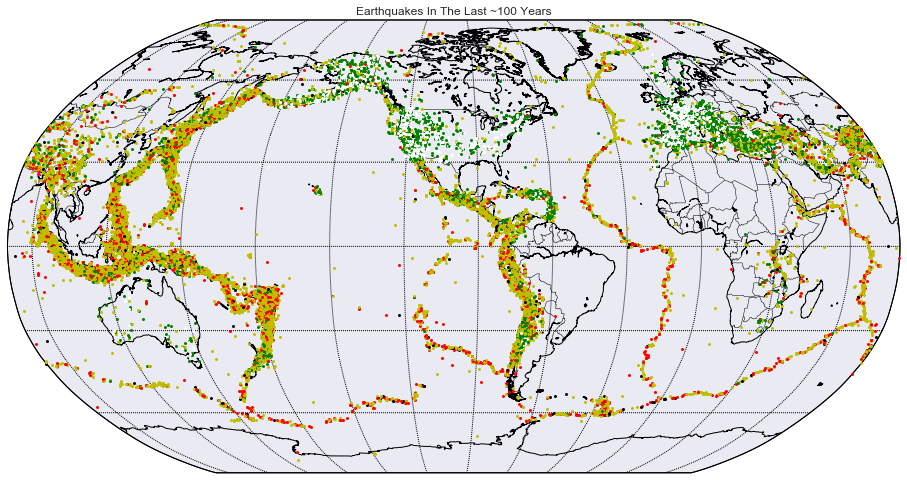

In [9]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(16,12))
subset = quakes.sample(frac=0.1)


my_map = Basemap(projection='robin', lat_0=0, lon_0=-100,
              resolution='l', area_thresh=1000.0)

lats = np.array(subset.latitude)
longs = np.array(subset.longitude)
mags = np.array(subset.mag)
colors = np.array(subset.color)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))

for lon, lat, mag, col in zip(longs, lats, mags, colors):
    x,y = my_map(lon, lat)
    my_map.plot(x, y, col, markersize=3)
    
plt.title('Earthquakes In The Last ~100 Years')
plt.show()

### Models

We looked at two simple models, Random Forest Classifier and Logistic Regression

In [10]:
logistic = LogisticRegression()
random = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

models = {'Logistic': logistic, 'RandomForest': random}

Helper functions to help us iterate through our process

In [11]:
def cross_validate(model, X, y, cv=3):
    return cross_validation.cross_val_score(model, X, y, cv=cv).mean()

def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

# iterates over all different models and print out their results of train_test_splitter
def test_models(models, X, y):
    for modelName, model in models.iteritems():
        print modelName
        X_train, X_test, y_train, y_test, model = train_test_splitter(model, X, y, train_size=0.5)
        print model.score(X_test, y_test)

### Data Cleaning/Feature Engineering

Our MVP was to create a model that will predict the classification of the magnitude given the latitude, longitude, and other information such as time.

Since magnitude is a continous variable that has infinite range, we had to classify it which we showed above. After classifying the magnitudes we created models to train
Another feature we thought would be interesting was classifying magnitude type. We were able to classify the encoding with the following look up there [here](http://earthquake.usgs.gov/earthquakes/eventpage/terms.php).

We classified the time by adding year, hour, month column in hopes to improve our performance.

Everytime we added a new feature, our score consistently increased.

In [12]:
# classification without the magnitude of less than 3 "tiny"
def magclassify1(mag):
    if mag < 4:
        return 0
    elif mag < 5:
        return 1
    elif mag < 6:
        return 2
    elif mag < 7:
        return 3
    elif mag < 8:
        return 4
    elif mag >= 8:
        return 5
    
# 
def magclassify(mag):
    if mag < 3:
        return 0
    elif mag < 4:
        return 1
    elif mag < 5:
        return 2
    elif mag < 6:
        return 3
    elif mag < 7:
        return 4
    elif mag < 8:
        return 5
    elif mag >= 8:
        return 6    

def classifyMagType(magType):
    duration = ["Md", "md"]
    local = ["ml"]
    shortPS = ["mb_lg", "lg", "mblg"]
    shortPeriodWave = ["mb"]
    twenty = ["ms", "ms_20"]
    moment = ["mi", "mwp"]
    energy = ["me"]
    
    mw = ["mw", "mwb", "mwc","mwr","mww"]
    magType = str(magType).lower()
    if magType in duration:
        return 0
    elif magType in local:
        return 1
    elif magType in shortPS:
        return 2
    elif magType in shortPeriodWave:
        return 3
    elif magType in twenty:
        return 4
    elif magType in moment:
        return 5
    elif magType in energy:
        return 6
    elif magType in mw:
        return 7
    else:
        return 8    
    
def parse_date(Dates):
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

In [13]:
def add_features():
    quakes["magClassified"] = quakes["mag"].apply(magclassify)
    quakes["magClassified1"] = quakes["mag"].apply(magclassify1)
    quakes["depth"] = quakes["depth"].fillna(quakes["depth"].median())
    quakes["magTypeClassified"] =  quakes["magType"].apply(classifyMagType)
    quakes["year"] = quakes.time.apply(lambda x: parse_date(x)[0])
    quakes["month"] = quakes.time.apply(lambda x: parse_date(x)[1])
    quakes["hour"] = quakes.time.apply(lambda x: parse_date(x)[3])
    quakes["country"] = quakes.place.apply(lambda x: str(x).split(", ")[-1])

In [14]:
add_features()

Only using latitude and longitude gives us decent score of 77.3% with RandomForest and 68.5% with Logistic model. Most of the earthquakes occur near a fault line which means they are very clustered. Random Forest does a much better job identifying these clusters

In [15]:
predictors = ["latitude", "longitude"]
test_models(models, quakes[predictors], quakes.magClassified1)

RandomForest
0.77436794727
Logistic
0.686419163629


Adding deph increases random forest by 1%

In [16]:
predictors = ["latitude", "longitude", "depth"]
test_models(models, quakes[predictors], quakes.magClassified1)

RandomForest
0.783925888833
Logistic
0.695284205378


MagTypeClassified definitely helps predicting the magnitude type

In [17]:
predictors = ["latitude", "longitude", "depth", "magTypeClassified"]
test_models(models, quakes[predictors], quakes.magClassified1)

RandomForest
0.846353833075
Logistic
0.704615062128


In [18]:
predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month", "hour"]
test_models(models, quakes[predictors], quakes.magClassified1)

RandomForest
0.857041376018
Logistic
0.703235085186


Random Forest Classifier continues to improve as we add more features because it has more features to split and make better decision trees. Adding new features doesn't really seem to increase our score that much for the logistic model. We suspect that this is most likely because logistic model is not very good at making sense of lat long data by clustering them. Most of the new features we added are label encodings of catergorical data. Logistic model might perform better if we one hot encode these catergorical data. 

### Tuning

We looked into tuning our Random Forest Classifier as well, using GridSearchCV. We looked into tuning 3 of the parameters in the Random Forest, to try to get a better model without overfitting. This basically ran through the model fitting for each of the parameters passed in, an calculated which ones were the best. We then graphed the different outcomes so we could visualize the impact they were making

[mean: 0.67180, std: 0.00042, params: {'min_samples_leaf': 1}, mean: 0.67796, std: 0.00043, params: {'min_samples_leaf': 2}, mean: 0.68419, std: 0.00076, params: {'min_samples_leaf': 3}, mean: 0.68904, std: 0.00106, params: {'min_samples_leaf': 4}, mean: 0.69052, std: 0.00047, params: {'min_samples_leaf': 5}, mean: 0.69286, std: 0.00016, params: {'min_samples_leaf': 6}, mean: 0.69424, std: 0.00082, params: {'min_samples_leaf': 7}, mean: 0.69444, std: 0.00081, params: {'min_samples_leaf': 8}, mean: 0.69511, std: 0.00087, params: {'min_samples_leaf': 9}, mean: 0.69651, std: 0.00022, params: {'min_samples_leaf': 10}, mean: 0.69644, std: 0.00055, params: {'min_samples_leaf': 11}, mean: 0.69627, std: 0.00078, params: {'min_samples_leaf': 12}, mean: 0.69697, std: 0.00089, params: {'min_samples_leaf': 13}, mean: 0.69762, std: 0.00104, params: {'min_samples_leaf': 14}, mean: 0.69726, std: 0.00107, params: {'min_samples_leaf': 15}]


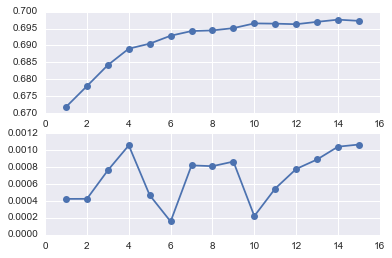

In [19]:
from sklearn.grid_search import GridSearchCV

parameters = [{'min_samples_leaf': np.arange(1,16)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

predictors = ["latitude", "longitude", "depth", "year"]

X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)

clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

print clf.grid_scores_

res = zip(*[(f1m, f1s.std(), p['min_samples_leaf']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

In [20]:
print clf.best_params_

{'min_samples_leaf': 14}


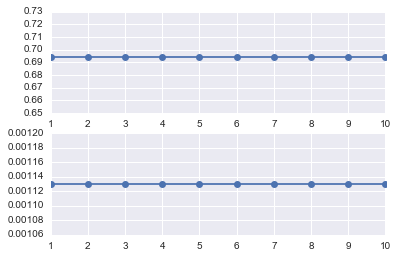

{'min_samples_split': 1}


In [21]:
parameters = [{'min_samples_split': np.arange(1,11)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

# predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
predictors = ["latitude", "longitude", "depth", "year"]

X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)


clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

res = zip(*[(f1m, f1s.std(), p['min_samples_split']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

print clf.best_params_

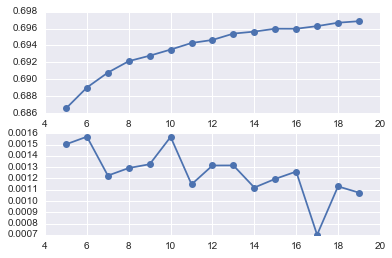

{'n_estimators': 19}


In [22]:
parameters = [{'n_estimators': np.arange(5,20)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

# predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
predictors = ["latitude", "longitude", "depth", "year"]

X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)


clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

res = zip(*[(f1m, f1s.std(), p['n_estimators']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

print clf.best_params_

In [23]:
predictors = ["latitude", "longitude", "depth", "year"]
# predictors = ["latitude", "longitude"]

logistic = LogisticRegression()


random = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)
models = {'Logistic': logistic, 'RandomForest': random}

print "Before Tuning: \n", test_models(models, quakes[predictors], quakes.magClassified)

random = RandomForestClassifier(random_state=1, n_estimators=19, min_samples_split=1, min_samples_leaf=15)
models = {'Logistic': logistic, 'RandomForest': random}
print "\n"
print "After Tuning: " , test_models(models, quakes[predictors], quakes.magClassified)

Before Tuning: 
RandomForest
0.696096470287
Logistic
0.52193697523
None


After Tuning:  RandomForest
0.701761945243
Logistic
0.521599259354
None


As shown, despite our grid search finding the 'best' parameters, the model score didn't really change in any significant way, maybe increasing by a small margin. We believe that the tuning wasn't enough to really push over the decisions in the tree to significant ways, therefore not affecting the model too heavily

### Heatmap

We wanted to visualize our results using a heatmap. Basically, you could pass in a longitude and latitude, and it would create a grid around that point and see which type of earthquake would be most likely at each point around the quake, to see context. We found that the results were not very interesting, as the same type of earthquake was predicted all around the center point for basically all cases, even with the grid being a whole latitude or longitude degree seperation. This was pretty disappointing, but we learned that we needed to refocus our question to find out something more interesting or compelling. 

In [24]:
alg = RandomForestClassifier(random_state=1, n_estimators=19, min_samples_split=4, min_samples_leaf=10)

predictors = ["latitude", "longitude"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [25]:
lat = 42.00000
lon = -71.00000

center = [lon, lat]

def point_grid(center, size):
    points = []
    for i in range(0,size/2):
        center[0] -= 1
        center[1] -= 1
    Matrix = [[0 for x in range(size)] for x in range(size)] 
    
    for i in range(1,size + 1):
        for j in range(1, size + 1):
            Matrix[i-1][j-1] = ((center[0] + 1*j), (center[1] + 1*i))

    return Matrix
    
print point_grid(center, 5)


[[(-72.0, 41.0), (-71.0, 41.0), (-70.0, 41.0), (-69.0, 41.0), (-68.0, 41.0)], [(-72.0, 42.0), (-71.0, 42.0), (-70.0, 42.0), (-69.0, 42.0), (-68.0, 42.0)], [(-72.0, 43.0), (-71.0, 43.0), (-70.0, 43.0), (-69.0, 43.0), (-68.0, 43.0)], [(-72.0, 44.0), (-71.0, 44.0), (-70.0, 44.0), (-69.0, 44.0), (-68.0, 44.0)], [(-72.0, 45.0), (-71.0, 45.0), (-70.0, 45.0), (-69.0, 45.0), (-68.0, 45.0)]]


In [26]:
lat =37.352693
lon = -122.119904
center = [lon, lat]

def heatmap(quakesLoc):
    size = len(quakesLoc[0])
    Scores = [[0 for x in range(size)] for x in range(size)] 
    
    for i in range(0,size):
        for j in range(0,size):
            
            point = list(quakesLoc[i][j])
            score = max(alg.predict_proba(point)[0])
            Scores[i][j] = score
            
    sns.heatmap(Scores, annot=True, linewidths = 0.2)
    sns.plt.show()

def predmap(quakesLoc):
    size = len(quakesLoc[0])
    Predictions = [[0 for x in range(size)] for x in range(size)] 
    
    for i in range(0,size):
        for j in range(0,size):
            
            point = list(quakesLoc[i][j])
            predict = alg.predict(point)
            Predictions[i][j] = predict.item(0)
            
    sns.heatmap(Predictions, annot=True, linewidths = 0.2)
    sns.plt.show()


/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

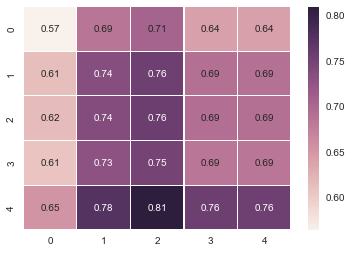

/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

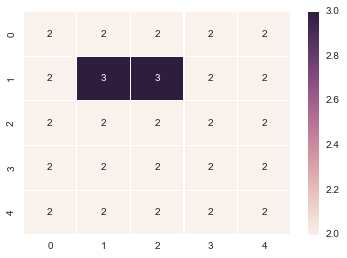

In [27]:
lat = 37
lon = -50

center = [lon, lat]

heatmap(point_grid(center,5))
predmap(point_grid(center,5))

As shown, the last heatmap shows a grid of all level 1 classifed earthquakes, which isn't particularily interesting or compelling

### Clustering using DBSCAN

One feature that we really wanted to add was some sort of fault classification. Location of the fault lines are very important for earthquake occurrences since most of them happen on fault lines. We weren't able to find any resources to easily map each lat and long to a specific fault line so we decided to try the classification ourselves by finding clusters.

We decided to use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) [link](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) on sklearn to create the clusters.

The result was pretty disappointing. It was able to extract interesting clusters such as the ring of fire but the result was not what we were expecting

Estimated number of clusters: 69


/Users/bumho/anaconda/lib/python2.7/site-packages/matplotlib/lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


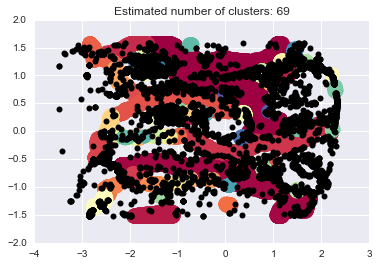

In [28]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(quakes[['latitude', 'longitude']])

# Compute DBSCAN
db = DBSCAN(eps=.03, min_samples=50).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

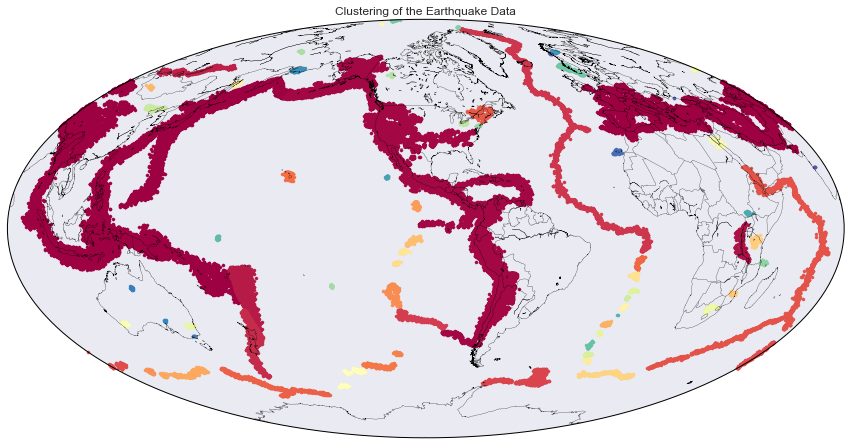

In [32]:
plt.figure(figsize=(15,15))
map = Basemap(projection='hammer',lat_0=0,lon_0=-100,resolution='l')
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)

# x,y = map(yy, xx)
# map.scatter(x,y ,10,marker='o',color='b')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels == k)
    
    filtered = quakes[['latitude', 'longitude']][class_member_mask & core_samples_mask]

    x = filtered.latitude
    y = filtered.longitude
    
    x,y = map(np.array(y), np.array(x))
    map.scatter(x,y ,10,marker='o',color=col)

plt.title('Clustering of the Earthquake Data')
plt.show()

### Transition to focusing on California

We realized that our findings weren't all that interesting. Most of our predictions were either 0 or 1 which corresponds to "minor" or "light". If we take a closer look at our data, this phenomenon is totally expected. The majority of the earthquake data that we were provided had the magnitude classificaiton of 0 or 1 which meant that most of our predictions would be the same. One of the major flaws in our question was that we wanted to predict some of the extreme cases but models always reflect the data that we train on and since the extreme events were rare, the predictions of such extreme events were also rare. 

The predictions that we made with the world's earthquake data weren't all that interesting so we decided to focus on a specific region, California and try to tell a story related to the specific area. California is known for many earthquake occurrences because San Andreas fault line goes through California. 

We used Kernal Density graph to observe the distribution of the earthquakes in the California area. We also generated a probably graph to predict the magnitude type of the earthquake given that an earthquake has happened.

In [34]:
quakes["country"] = quakes.place.apply(lambda x: str(x).split(", ")[-1])
print type(quakes.country.value_counts())
print quakes.country.value_counts()

<class 'pandas.core.series.Series'>
Indonesia                                  41514
Alaska                                     37083
CA                                         34014
Chile                                      33567
Japan                                      24219
California                                 21970
Papua New Guinea                           21812
Greece                                     19337
Mexico                                     17996
Philippines                                12731
Japan region                               11730
western Turkey                             11572
Fiji region                                10139
Kuril Islands                               8995
Argentina                                   8972
Vanuatu                                     8397
MX                                          8064
Russia                                      7881
Central Alaska                              7787
Tonga                            

In [36]:
ca = quakes[(quakes["country"] =="California")| (quakes["country"] =="CA")]

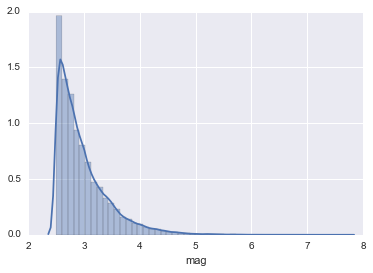

In [39]:
sns.distplot(ca.mag)

In [40]:
def get_marker_color(magnitude):
    if magnitude < 3.0:
        return ('wo') # tiny
    elif magnitude < 4.0:
        return ('go') # minor
    elif magnitude < 5.0:
        return ('yo') # light
    elif magnitude < 5.0:
        return ('mo') # moderate
    elif magnitude < 6.0:
        return ('ro') # strong
    elif magnitude < 7.0:
        return ('ko') # major
    else:
        return ('ko') # great
    

### Plotting California Earthquakes Based Off Magnitude

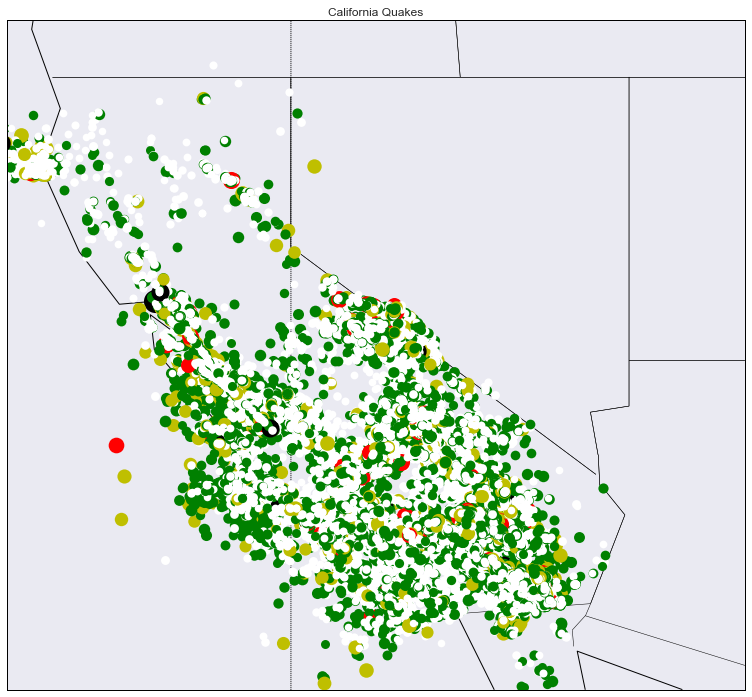

In [44]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(16,12))

my_map = Basemap(llcrnrlon=-125, llcrnrlat=31.2, urcrnrlon=-112, urcrnrlat=43, projection='cyl',
              resolution='c' )


lats = np.array(ca.latitude)
longs = np.array(ca.longitude)
mags = np.array(ca.mag)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.drawstates()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))
# my_map.bluemarble()

for lon, lat, mag in zip(longs, lats, mags):
    x,y = my_map(lon, lat)
    marker_string = get_marker_color(mag)
    my_map.plot(x, y, marker_string, markersize=mag*3)
    
plt.title('California Quakes')
plt.show()

In [46]:
import seaborn as sns

def proba_graph(lat, lon, model):
    plt.figure(figsize=(12,8))
    point = [lat, lon]
    prediction = model.predict_proba(point)
    labels = ["tiny", "minor", "light", "moderate", "strong", "major"]
    
    ax = sns.barplot(labels,prediction[0])
    total = float(len(prediction))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + 0.2, height+0.01, '%1.1f'%(height/total * 100 ),  fontsize=15, )
    
    sns.axlabel("Earthquake Classification Type", "Probability")
    plt.title("Earthquake Magnitude Probabilities")
    plt.ylim([0 ,1])
    
    plt.show()
    
    return prediction

We decided to add "tiny" field (magnitidue of less than 3) because without it our model predicts minor around 95 percent of the times which is not that interesting

In [47]:
predictors = ["latitude", "longitude"]
alg2 = RandomForestClassifier(random_state=1, n_estimators=19, min_samples_split=4, min_samples_leaf=15)
X_train, X_test, y_train, y_test = train_test_split(ca[predictors], ca.magClassified1, train_size=.5)
alg2.fit(X_train, y_train)
print alg2.score(X_test, y_test)

0.958416690483


In [48]:
predictors = ["latitude", "longitude"]
alg = RandomForestClassifier(random_state=1, n_estimators=19, min_samples_split=4, min_samples_leaf=15)
X_train, X_test, y_train, y_test = train_test_split(ca[predictors], ca.magClassified, train_size=.5)
alg.fit(X_train, y_train)
print alg.score(X_test, y_test)

0.645934552729


In [49]:
from pylab import *
from sklearn.neighbors.kde import KernelDensity
from matplotlib import path
import random

# min max lat long are tuned for california
def makeNearestNeighborsDensityPlot(data, min_lat = 31, max_lat = 43, min_lon = -125, max_lon = -112, cmap = 'bwr', res = .1):
    
    geolocated = data 
    
    print "model fitting"
    model = KernelDensity(kernel='gaussian', bandwidth = 1).fit(geolocated[['latitude', 'longitude']])
    
    #Create a grid of points at which to predict. 
    x = np.arange(min_lat, max_lat, res)
    y = np.arange(min_lon, max_lon, res)
    X, Y = meshgrid(x, y)
    numel = len(X) * len(X[0, :])
    Z = np.zeros(X.shape)
    unraveled_x = X.reshape([numel, 1])
    unraveled_y = Y.reshape([numel, 1])
    data_to_eval = np.hstack([unraveled_x, unraveled_y])
    
    #Make predictions using appropriate model. 
    print "making predictions"
    density = np.exp(model.score_samples(data_to_eval)) 
    color_min = 0
    color_max = density.max()

    #Make map. 
    print "making map"
    figure(figsize = [15, 15])    
    m = Basemap(llcrnrlat = min_lat, urcrnrlat = max_lat, llcrnrlon = min_lon, urcrnrlon=max_lon, resolution='l', fix_aspect = False)

    m.drawcoastlines()
    
    density = density.reshape(X.shape)
    contourf(Y, X, density, levels = np.linspace(color_min, color_max, 50))
    m.drawcoastlines(linewidth = 2)
    m.drawcountries(linewidth = 2)
    m.drawstates(linewidth = 2)
    colorbar()
    set_cmap(cmap)

    show()
    print "done"
    return density

model fitting
making predictions
making map


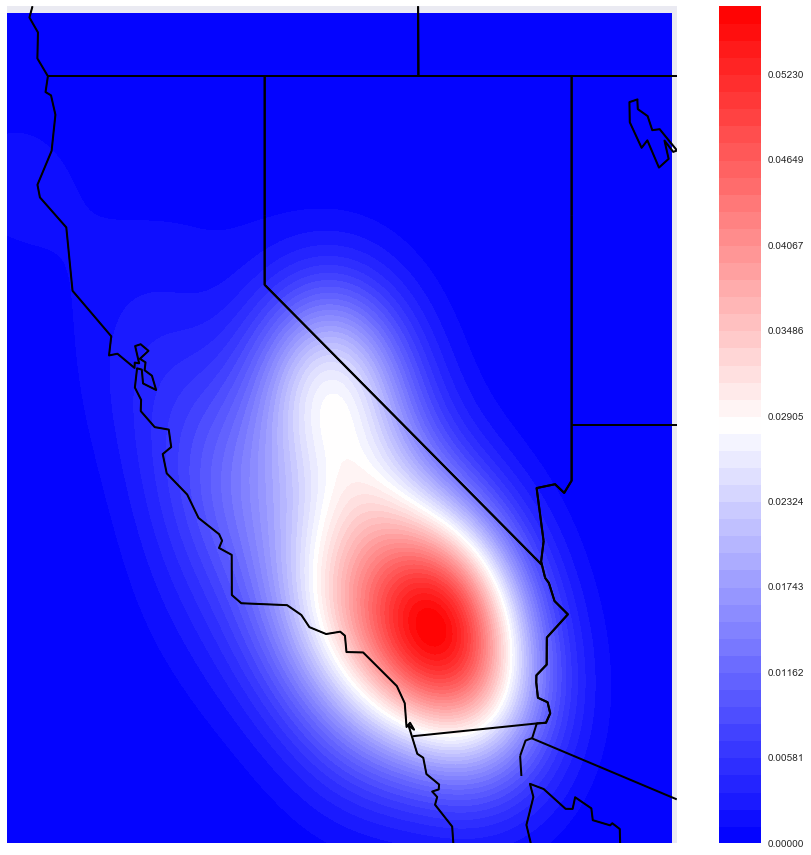

done


In [50]:
density = makeNearestNeighborsDensityPlot(ca)

We wanted to see if our Kernal Density Plot will show us the San Andreas Fault that runs through California since the occurrences of Earthquakes would be concentrated along the fault lines. As we can see from the graph above, it does not really show the fault line. One of the reasons this is not the case is the Kernal Density assumes that the density is spherical. Our density graph should not be spherical and it should be more linear following the supposed fault line. Also when you take a look at the distribution of the earthquake points, it does not seem to show a strong linear relationship in the lat long.

In [51]:
# given a lat long gives the density value of the earthquakes
def getDensity(density, x_in, y_in, min_lat = 31, max_lat = 43, min_lon = -125, max_lon = -112, res = .1):
    x = np.arange(min_lat, max_lat, res)
    y = np.arange(min_lon, max_lon, res)
    x_out = 0
    y_out = 0
    
    for i in range(len(x)):
        if x_in < x[i]:
            x_out = i
            break
            
    for i in range(len(y)):
        if y_in < y[i]:
            y_out = i
            break
            
    return density[y_out] [x_out]

### Interpretation

The lat long pair of 33.9387, -116.372171 corresponds to Desert Hot Springs which is one of the cities in the red zone in our kernal density graph. This means that out of all of the Earthquakes that happened in the last 100 years in California, 5 percent of the Earthquakes had the epicenter located at Desert Hot Springs. 

Using this information with our model, predicts the type of earthquake that would occur, give that there *is* already and earthquake. Given that there is an earthquake at Desert Hot Springs, 55.8% chance that it is below magnitude of 3 and etc.

In [52]:
print getDensity(density, 33.9387, -116.372171)

0.0538517599553


/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


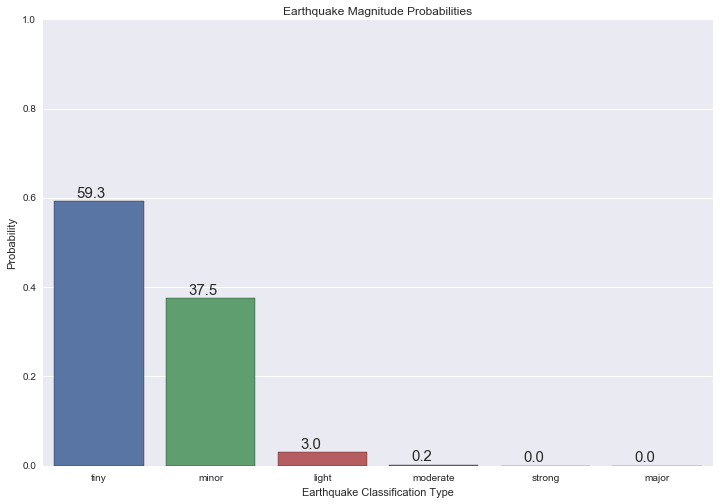

array([[ 0.5925594 ,  0.37532007,  0.03024083,  0.0018797 ,  0.        ,
         0.        ]])

In [53]:
proba_graph(33.9387, -116.372171, alg)

## Changing the World

I think our model and analysis has potential to change the world, but it is not quite there. We do have a relatively successful model that can predict which magnitude classification will occur given that there is an earthquake. However, the most difficult thing about this project is predicting if an earthquake at all will happen or not in a given spot or over a given timeframe.

The next steps in the project would be to find a way to encode that when an earthquake does happen, it is also not happening literally everywhere else on the globe. However, we don't want to drown out that one data point where there is a quake, so we would have to do some sort of weighting in order to account for that important point. We aren't sure exactly how we could do this, however. Our model doesn't take into account other factors, like the prediction of said earthquake over a long time period.  If we incorporated time into our model, we could hopefully give a prediction that looked something like: "In the next 10 years, there is a 24% chance that a 'moderate' earthquake will occur near this latitude - longitude point X,Y." We also didn't take into account that larger earthquakes will affect a large area. Right now, we are only using the latitude and the longitude of the center of the quake, which does not take into account the area of shaking that will occur.

Clearly, if this problem were easier, a tool like this would already exist and people would know more accurately when earthquakes would occur, rather than randomly. Earthquakes cause millions of dollars of damage, so there is definitely a need for this tool that would give warning into earthquakes more accurately than current models. We are also dealing with only past earthquake data to predict future earthquakes. In reality to predict an earthquake, a lot of the earthquakes physics needs to be incorporated into the model to make accurate predictions. A future step would be to incorporate the population and infrastructure of the area around where we predict the earthquake to be in order to create a sort of 'damage calculation' that could determine how dangerous the earthquake would actually be. 

## Learning Goals

We learned a lot during this project about feature engineering and classifying, parameter tuning, kernel density, heatmaps and basemaps, and other visualizations in this project. 

Looking back, we think we addressed the first part of our goals well. Fortunately, the USGS dataset we had was basically complete, it had no null values. We did have to do some cleaning when dealing with magnitude classification types, but we didn't end up using those in our model, only the actual magnitude that we split into our own classifications. After refocusing our question, we had to do some more cleaning to look at the points in California, but this ended up not being too difficult. 

We think the hardest part for us was figuring out  our question. We kind of had a mid-project crisis when we realized that our model, although seemingly accurate, wasn't particularly interesting or useful. It was predicting minor or light earthquakes almost all of the time, which makes sense given our dataset had a huge majority of those cases, but is also boring.

Because this project wasn't scaffolded into a Kaggle competition, we had to figure out how we wanted to tell our story of the data and what we learned exploring and modelling it. I think we learned a lot in this regard. We struggled trying to find how we could tell a compelling story with the data and model that we had that could actually be useful in the quest to 'change the world.' In only the last couple days before the project was due, we refocused our question. We decided to narrow down our sample to only California earthquakes. We still wanted to have a model that predicted more than what category of quake it was going to be, so we investigated Kernel Density. Using Kernal Density graph, we were able to generate an interesting visualization. While we didn’t end up at a place where we imagined we would be in the beginning, we learned a lot especially in formulating our questions and coming up with a compelling story.